In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from tableone import TableOne
wd = '/mnt/UCD/PEDS/RI Biostatistics Core/Shared/Shared Projects/Laura/BDC/Projects/Kim Driscoll/Bring BG Down/'
import warnings;
warnings.filterwarnings('ignore');

In [2]:
# Enable cell magic for Rpy2 interface
%load_ext rpy2.ipython

# Participant and Data Characteristics

## Table 1: Participant Characteristics at Visit 1

In [3]:
df = pd.read_csv(wd+'Data_Cleaned/bbgd_master.csv')
# Make pretty variables for Table 1
df["Private Insurance"] = ['Yes' if i == 1 else 'No' if i==0 else np.nan for i in df['p_insurance_commercial']]
df["Total Household Income"] = df["par_income"].replace({1:"Under $5K",2:"$5K-$9,999",3:"$10K-$19,999",4:"$20K-29,999", 
                                                   5:"$30K-39,999",6:"$40K-49,999",7:"$50K-59,999",8:"$60K-69,999",
                                                   9:"$70K-79,999",10:"$80K-89,999",11:"$90K-99,999",12:"$100K +"})
df["Parent's Marital Status"] = df["par_marital"].replace({1:"Married to Child's Biologic Father",2:"Married to Child's Stepfather", 
                                                  3:"Separated",4:"Divorced",5:"Widowed",6:"Single",7:"Living with Domestic Partner"})
df["Highest Degree Parent Completed"] = df["par_degree"].replace({1:"No Degree",2:"High School",3:"Associate's",4:"Bachelor's",
                                                                  5:"Master's",6:"Doctoral"})
df["Parent Ethnicity"] = df["par_ethnicity"].replace({1:"Hispanic or Latino",2:"Not Hispanic or Latino"})
df["Parent Race"] = df["par_race"].replace({1:"American Indian or Alaskan Native",2:"Asian",3:"Black or African American",
                                            4:"Native Hawaiian or Pacific Islander",5:"White"})
df["Primary Male Caretaker"] = df["par_race"].replace({1:"Father",2:"Stepfather",3:"Grandfather",4:"Uncle",5:"Mother's boyfriend/partner",6:"Other"})
# Main outcomes
df["Parent Maintain High BG of HFS"] = df["p_maintain_high"]
df["Parent Worry/Helplessness Subscale of HFS"] = df["p_helpless"]
df["Parent Social Consequences Subscale of HFS"] = df["p_social"]
df["Parent GAD-7 Score"] = df["p_gad_total"]
# Make table 1
cols = ["Parent Maintain High BG of HFS","Parent Worry/Helplessness Subscale of HFS",
        "Parent Social Consequences Subscale of HFS","Parent GAD-7 Score",
        "Private Insurance","Total Household Income","Parent's Marital Status",
       "Highest Degree Parent Completed","Parent Race","Parent Ethnicity","Primary Male Caretaker"]

# Print
t1 = TableOne(df.query("studyvisit == 1"),columns=cols,groupby='treatment_group',pval=True,display_all=True,
             normal_test=True,tukey_test=True,dip_test=True)
t1

Grouped by treatment_group                                            
                                                                                                             Missing     Overall           0           1 P-Value
n                                                                                                                             43          22          21        
Parent Maintain High BG of HFS, mean (SD)                                                                          1   6.5 (2.8)   6.0 (3.0)   7.0 (2.6)   0.303
Parent Worry/Helplessness Subscale of HFS, mean (SD)                                                               0  22.2 (6.4)  20.1 (5.9)  24.3 (6.2)   0.027
Parent Social Consequences Subscale of HFS, mean (SD)                                                              1   4.9 (3.2)   4.1 (2.6)   5.7 (3.6)   0.115
Parent GAD-7 Score, mean (SD)                                                                                      0  13.5 (4.9)  12.3 (3.9)  14.7 (5.6)   0.116
Private Insurance, n (%)                              No                                                           0   11 (25.6)    5 (22.7)    6 (28.6)   0.929
                                                      Yes                                                              32 (74.4)   17 (77.3)   15 (71.4)        
Total Household Income, n (%)                         $100K +                                                      2   18 (43.9)    9 (40.9)    9 (47.4)   0.902
                                                      $20K-29,999                                                        3 (7.3)     2 (9.1)     1 (5.3)        
                                                      $30K-39,999                                                        3 (7.3)     2 (9.1)     1 (5.3)        
                                                      $40K-49,999                                                        2 (4.9)     2 (9.1)                    
                                                      $50K-59,999                                                        3 (7.3)     1 (4.5)    2 (10.5)        
                                                      $60K-69,999                                                        2 (4.9)     1 (4.5)     1 (5.3)        
                                                      $70K-79,999                                                        4 (9.8)     2 (9.1)    2 (10.5)        
                                                      $80K-89,999                                                        2 (4.9)     1 (4.5)     1 (5.3)        
                                                      $90K-99,999                                                        3 (7.3)     2 (9.1)     1 (5.3)        
                                                      Under $5K                                                          1 (2.4)                 1 (5.3)        
Parent's Marital Status, n (%)                        Divorced                                                     1    8 (19.0)    3 (14.3)    5 (23.8)   0.201
                                                      Living with Domestic Partner                                       2 (4.8)                 2 (9.5)        
                                                      Married to Child's Biologic Father                               30 (71.4)   16 (76.2)   14 (66.7)        
                                                      Widowed                                                            2 (4.8)     2 (9.5)                    
Highest Degree Parent Completed, n (%)                Associate's                                                  0    6 (14.0)                6 (28.6)   0.090
                                                      Bachelor's                                                       17 (39.5)    9 (40.9)    8 (38.1)        
                                                      Doctoral   

Highest Degree Parent Completed, Total Household Income, and Parent's Marital Status were not significant by Fisher's exact test either (p = 0.063, 0.969, and 0.297 respectively).

## Outcome Plots

Two of the four outcomes were reasonably normally distributed, but 'p_social' and 'p_gad_total' were skewed and unable to be log-transformed due to many 0 values.

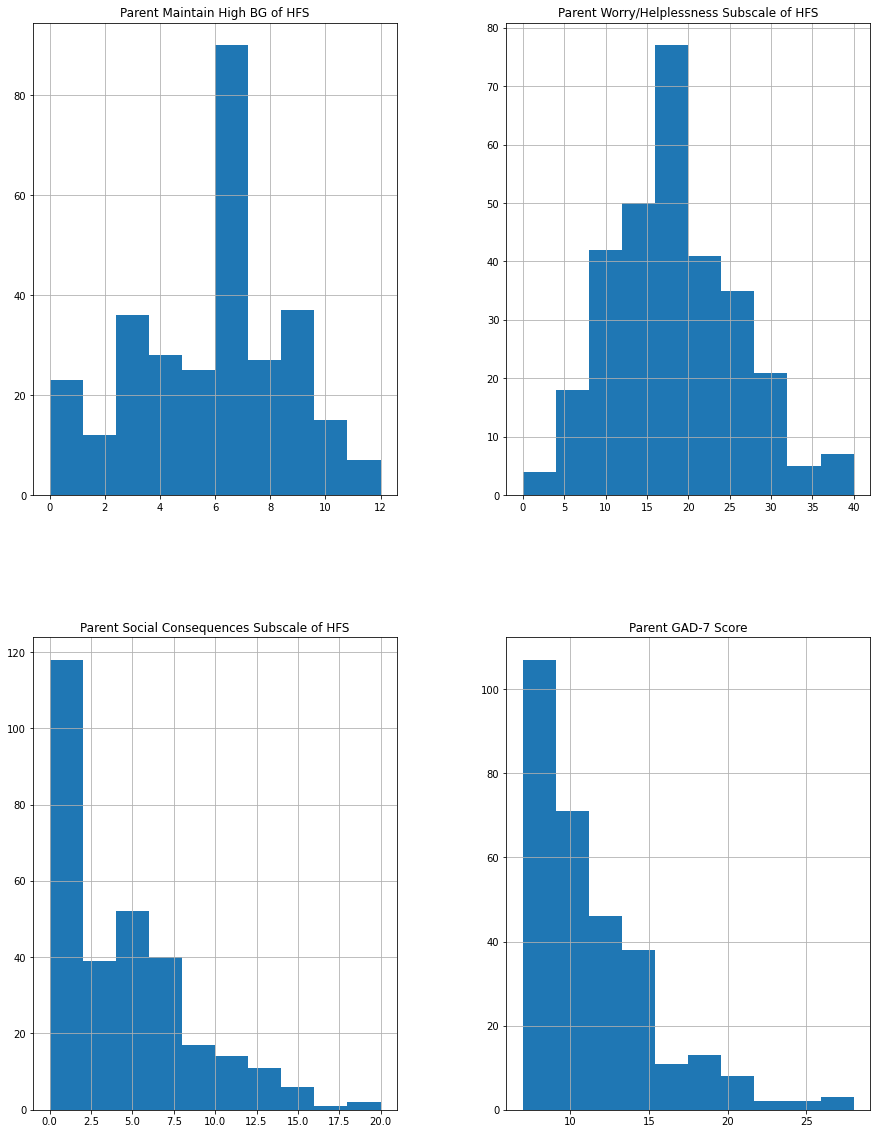

In [4]:
# Define main outcomes for plotting
var_list = ["Parent Maintain High BG of HFS","Parent Worry/Helplessness Subscale of HFS","Parent Social Consequences Subscale of HFS","Parent GAD-7 Score"]
# Plot
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df[var_list].hist(ax = ax);# Semicolon hides the matplotlib descriptions in Jupyter

# Model Results
All four outcomes were evaluated using a linear mixed model with random intercept for participant. Model assumptions were checked visually. Study visit was treated as a categorical variable to help account for non-linear trends and varying time to visits. In the following tables, "C(studyvisit)[T.2]" refers to study visit 2, "C(studyvisit)[T.3]" to visit 3, etc.

Income was split into three groups: Under \\$5K-\\$29,999 (reference group); \\$30K-\\$69,999 ("C(par_income)[T.Interval(4, 8, closed='right')]"); and \\$70K-\\$100K+ ("C(par_income)[T.Interval(8, 12, closed='right')]").

In [5]:
# Import age information
v1_dates = pd.read_csv(wd+'Data_Cleaned/v1_dates.csv',usecols=['ID','T1','T1D_Onset'])
v1_dates.rename(columns={'ID':'participant_id','T1':'t1_date','T1D_Onset':'t1d_onset'},inplace=True)
# Merge, convert to date
df = df.merge(v1_dates,how='left',on='participant_id')
df['t1_date']=pd.to_datetime(df['t1_date'], errors='coerce', format='%m/%d/%y')
df['t1d_onset']=pd.to_datetime(df['t1d_onset'], errors='coerce', format='%m/%d/%y')
# Calculate age at T1
df['c_dob']= pd.to_datetime(df['c_dob'], errors='coerce', format='%m/%d/%y')
df['age']=df['t1_date']-df['c_dob']
df['age']=[float(t.days)/365.25 for t in df['age']]
# Calculate T1D duration at T1
df['t1d_duration']=df['t1_date']-df['t1d_onset']
df['t1d_duration']=[float(t.days)/365.25 for t in df['t1d_duration']]
# Cut income into three levels, fill down 
df['par_income'] = df.groupby('participant_id')['par_income'].ffill()
df['par_income'] = pd.cut(df['par_income'],[0,4,8,12])
df.to_csv('~/Desktop/df.csv')

In [6]:
# Residual plotting function
def plot_resid(model):
    fig, ax = plt.subplots(1,2,figsize = (15,10))
    res = model.resid
    kde = sns.kdeplot(mdf.resid, fill = True,ax=ax[0])
    kde.set_title("KDE Plot of Model Residuals")
    kde.set_xlabel("Residuals")
    qq = sm.qqplot(res,line='s',ax=ax[1])

## Raw Scores

### Parent Maintain High BG of HFS

#### Adjusted for Age

In [7]:
# Fit a random intercept for each participant
ri_mod = smf.mixedlm("p_maintain_high ~ C(studyvisit)*C(treatment_group)+par_income+age", 
                     df, groups=df["participant_id"],missing = "drop")
mdf = ri_mod.fit()
results_summary = mdf.summary()
results_summary.tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,3.082,1.726,1.785,0.074,-0.302,6.465
C(studyvisit)[T.2],0.343,0.527,0.650,0.515,-0.690,1.375
C(studyvisit)[T.3],1.403,0.527,2.663,0.008,0.370,2.436
C(studyvisit)[T.4],-0.417,0.501,-0.834,0.404,-1.399,0.564
C(studyvisit)[T.5],-0.341,0.548,-0.622,0.534,-1.415,0.734
C(studyvisit)[T.6],-0.518,0.508,-1.021,0.307,-1.514,0.477
C(studyvisit)[T.7],-0.699,0.508,-1.377,0.169,-1.694,0.296
C(studyvisit)[T.8],-0.523,0.501,-1.045,0.296,-1.505,0.458
C(treatment_group)[T.1],0.794,0.822,0.967,0.334,-0.816,2.405
"par_income[T.Interval(4, 8, closed='right')]",0.288,1.284,0.225,0.822,-2.229,2.806


#### Adjusted for T1D Duration

In [ ]:
# Fit a random intercept for each participant
ri_mod = smf.mixedlm("p_maintain_high ~ C(studyvisit)*C(treatment_group)+par_income+t1d_duration", 
                     df, groups=df["participant_id"],missing = "drop")
mdf = ri_mod.fit()
results_summary = mdf.summary()
results_summary.tables[1]

In [ ]:
plot_resid(mdf)

### Parent Worry/Helplessness Subscale of HFS

#### Adjusted for Age

In [ ]:
# Fit a random intercept for each participant
ri_mod = smf.mixedlm("p_helpless ~ C(studyvisit)*C(treatment_group)+par_income+age", 
                     df, groups=df["participant_id"],missing = "drop")
mdf = ri_mod.fit()
results_summary = mdf.summary()
results_summary.tables[1]

In [ ]:
plot_resid(mdf)

#### Adjusted for T1D Duration

In [ ]:
# Fit a random intercept for each participant
ri_mod = smf.mixedlm("p_helpless ~ C(studyvisit)*C(treatment_group)+par_income+t1d_duration", 
                     df, groups=df["participant_id"],missing = "drop")
mdf = ri_mod.fit()
results_summary = mdf.summary()
results_summary.tables[1]

In [ ]:
plot_resid(mdf)

### Parent Social Consequences Subscale of HFS

#### Adjusted for Age

In [ ]:
# Fit a random intercept for each participant
ri_mod = smf.mixedlm("p_social ~ C(studyvisit)*C(treatment_group)+par_income+age", 
                     df, groups=df["participant_id"],missing = "drop")
mdf = ri_mod.fit()
results_summary = mdf.summary()
results_summary.tables[1]

In [ ]:
plot_resid(mdf)

#### Adjusted for T1D Duration

In [ ]:
# Fit a random intercept for each participant
ri_mod = smf.mixedlm("p_social ~ C(studyvisit)*C(treatment_group)+par_income+t1d_duration", 
                     df, groups=df["participant_id"],missing = "drop")
mdf = ri_mod.fit()
results_summary = mdf.summary()
results_summary.tables[1]

In [ ]:
plot_resid(mdf)

### Parent GAD-7 Score

#### Adjusted for Age

In [ ]:
# Fit a random intercept for each participant
ri_mod = smf.mixedlm("p_gad_total ~ C(studyvisit)*C(treatment_group)+par_income+age", 
                     df, groups=df["participant_id"],missing = "drop")
mdf = ri_mod.fit()
results_summary = mdf.summary()
results_summary.tables[1]

In [ ]:
plot_resid(mdf)

#### Adjusted for T1D Duration

In [ ]:
# Fit a random intercept for each participant
ri_mod = smf.mixedlm("p_gad_total ~ C(studyvisit)*C(treatment_group)+par_income+t1d_duration", 
                     df, groups=df["participant_id"],missing = "drop")
mdf = ri_mod.fit()
results_summary = mdf.summary()
results_summary.tables[1]

In [ ]:
plot_resid(mdf)

## Elevated Scores vs. Not Elevated

All four outcomes were evaluated using a logistic mixed model with random intercept for participant. Coefficient estimates are reported on the log scale.

In [ ]:
# Make cutoffs:
# GAD-7 >=10 considered elevated
# Maintain High BG >=7 considered elevated
# Helplessness >=24 considered elevated
# Social Consequences >=9 considered elevated
df['p_elevated_maintain']=[float(1) if m >= 7 else float(0) if m < 7 else np.nan for m in df['p_maintain_high']]
df['p_elevated_helpless']=[float(1) if m >= 24 else float(0) if m < 24 else np.nan for m in df['p_helpless']]
df['p_elevated_social']=[float(1) if m >= 9 else float(0) if m < 9 else np.nan for m in df['p_social']]
df['p_elevated_gad']=[float(1) if m >= 10 else float(0) if m < 10 else np.nan for m in df['p_gad_total']]
# Make simplified DF for R
log_df = df[['participant_id','studyvisit','treatment_group','par_income','age','t1d_duration',
             'p_elevated_maintain','p_elevated_helpless','p_elevated_social','p_elevated_gad']].copy().dropna()
log_df['par_income'] = log_df['par_income'].astype('str')

### Parent Maintain High BG of HFS

#### Adjusted for Age

In [ ]:
%%R -i log_df
suppressMessages(library(lme4))
suppressMessages(library(lmerTest))
mod <- glmer(p_elevated_maintain ~ factor(studyvisit)*factor(treatment_group)+factor(par_income)+age+(1|participant_id),data = log_df,family = binomial(link = "logit"))
print(summary(mod)$coefficients[,c(1,4)])

#### Adjusted for T1D Duration

In [ ]:
%%R -i log_df
suppressMessages(library(lme4))
suppressMessages(library(lmerTest))
mod <- glmer(p_elevated_maintain ~ factor(studyvisit)*factor(treatment_group)+factor(par_income)+t1d_duration+(1|participant_id),data = log_df,family = binomial(link = "logit"))
print(summary(mod)$coefficients[,c(1,4)])

### Parent Worry/Helplessness Subscale of HFS

#### Adjusted for Age

In [ ]:
%%R -i log_df
suppressMessages(library(lme4))
suppressMessages(library(lmerTest))
mod <- glmer(p_elevated_helpless ~ factor(studyvisit)*factor(treatment_group)+factor(par_income)+age+(1|participant_id),data = log_df,family = binomial(link = "logit"))
print(summary(mod)$coefficients[,c(1,4)])

#### Adjusted for T1D Duration

In [ ]:
%%R -i log_df
suppressMessages(library(lme4))
suppressMessages(library(lmerTest))
mod <- glmer(p_elevated_helpless ~ factor(studyvisit)*factor(treatment_group)+factor(par_income)+t1d_duration+(1|participant_id),data = log_df,family = binomial(link = "logit"))
print(summary(mod)$coefficients[,c(1,4)])

### Parent Social Consequences Subscale of HFS

#### Adjusted for Age

In [ ]:
%%R -i log_df
suppressMessages(library(lme4))
suppressMessages(library(lmerTest))
mod <- glmer(p_elevated_social ~ factor(studyvisit)*factor(treatment_group)+factor(par_income)+age+(1|participant_id),data = log_df,family = binomial(link = "logit"))
print(summary(mod)$coefficients[,c(1,4)])

#### Adjusted for T1D Duration

In [ ]:
%%R -i log_df
suppressMessages(library(lme4))
suppressMessages(library(lmerTest))
mod <- glmer(p_elevated_social ~ factor(studyvisit)*factor(treatment_group)+factor(par_income)+t1d_duration+(1|participant_id),data = log_df,family = binomial(link = "logit"))
print(summary(mod)$coefficients[,c(1,4)])

### Parent GAD-7 Score

#### Adjusted for Age

In [ ]:
%%R -i log_df
suppressMessages(library(lme4))
suppressMessages(library(lmerTest))
mod <- glmer(p_elevated_gad ~ factor(studyvisit)*factor(treatment_group)+factor(par_income)+age+(1|participant_id),data = log_df,family = binomial(link = "logit"))
print(summary(mod)$coefficients[,c(1,4)])

#### Adjusted for T1D Duration

In [ ]:
%%R -i log_df
suppressMessages(library(lme4))
suppressMessages(library(lmerTest))
mod <- glmer(p_elevated_gad ~ factor(studyvisit)*factor(treatment_group)+factor(par_income)+t1d_duration+(1|participant_id),data = log_df,family = binomial(link = "logit"))
print(summary(mod)$coefficients[,c(1,4)])

In [ ]:
visit = [1,2,3,4] * 250
time = [float(v)*30 + np.random.normal(0,2) for v in visit]
y = [float(v + v^2 + v^3) + np.random.normal(0,1) for v in visit]
visit_means = []
df = pd.DataFrame({'y': y,'visit': visit,'time': time})
sns.lmplot(x = 'time',y = 'y',data = df)
sns.lmplot(x = 'time',y = 'y',data = df, order = 3)

In [ ]:
sns.pointplot(x='visit', y='y',data = df)